# Muon weighted nearest neighbours

This notebook follows this [tutorial](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/2-CITE-seq-PBMC-5k-Weighted-Neighbours.html). ARI and NMI metrics are calculated.

In [19]:
import os
os.environ[ 'NUMBA_CACHE_DIR' ] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113

import h5py
import hdf5plugin
import tables

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scanpy as sc
import anndata as ad
import muon as mu
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

import yaml
from pathlib import Path

## Load the data

In [31]:
config = yaml.safe_load(Path('../experiments/4_13176.yaml').read_text())
config

{'files': {'rna': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_13176_raw_rna.h5ad'],
  'protein': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_13176_raw_protein.h5ad'],
  'combined': ['/arc/project/st-jiaruid-1/yinian/pbmc/4_13176_raw_combined.h5ad'],
  'gene_indices': '/scratch/st-jiaruid-1/yinian/my_jupyter/scETM/scripts/gene_indices_2.pkl'},
 'model_params': {'n_epochs': 12000,
  'eval_every': 3000,
  'cell_type_col': 'cell_type',
  'day': 4,
  'donor': 13176,
  'rna_n_vars': 22085},
 'ckpt_dir': '/scratch/st-jiaruid-1/yinian/my_jupyter/scETM/results/'}

In [32]:
files = config['files']
model_params = config['model_params']
if model_params['cell_type_col'] == 'None':
    model_params['cell_type_col'] = None

In [33]:
rna_files = files['rna']
adata_rna = ad.concat([ad.read_h5ad(c_file) for c_file in rna_files], label="batch_indices")
protein_files = files['protein']
adata_protein = ad.concat([ad.read_h5ad(c_file) for c_file in protein_files], label="batch_indices")

## Analysis using Muon WNN

First, load the data.

In [34]:
mdata = mu.MuData({'rna': adata_rna, 'protein': adata_protein})

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


Construct the nearest neighbours for each of the modalities. Then, calculate the weightest nearest neighbours.

In [35]:
sc.pp.neighbors(mdata['rna'])
sc.pp.neighbors(mdata['protein'])

mu.pp.neighbors(mdata, key_added='wnn')

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/pynndescent/pynndes

Plot the UMAP

In [36]:
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


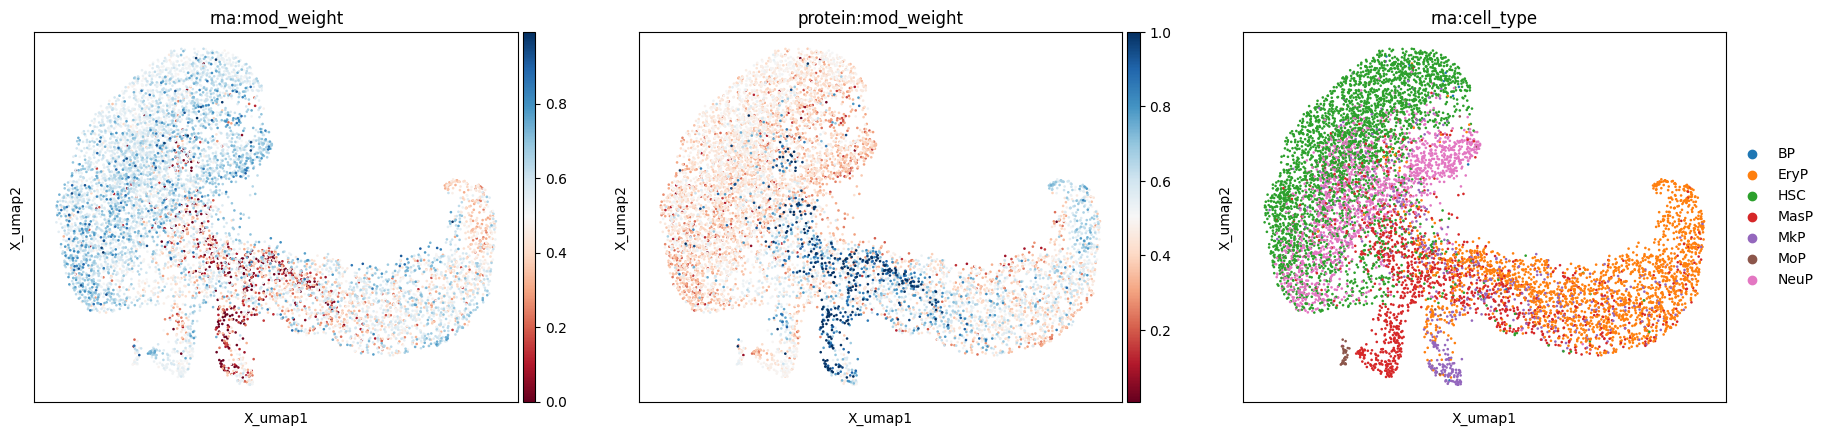

In [37]:
mu.pl.umap(mdata, color=['rna:mod_weight', 'protein:mod_weight', 'rna:cell_type'], cmap='RdBu')

Cluster and evaluate

In [38]:
for r in [0.07, 0.1, 0.13, 0.19, 0.22, 0.25, 0.28, 0.31, 0.35, 0.44, 0.64, 1]:
    sc.tl.leiden(mdata, resolution=r, neighbors_key='wnn', key_added='leiden_wnn')
    leiden_assignment = list(mdata.obs['leiden_wnn'].cat.codes)
    real_assignment = list(mdata['rna'].obs['cell_type'].cat.codes)
    ari = adjusted_rand_score(real_assignment, leiden_assignment)
    nmi = normalized_mutual_info_score(real_assignment, leiden_assignment)
    print(r, ari, nmi, ari+nmi)


0.07 0.31952634184141787 0.374203059215721 0.6937294010571389
0.1 0.39218298268199986 0.4348561911026428 0.8270391737846426
0.13 0.3760510966134802 0.40659342507536494 0.7826445216888451
0.19 0.3089039126827619 0.3773695386552879 0.6862734513380497
0.22 0.32577284576459753 0.3979769436174752 0.7237497893820728
0.25 0.35727608274566686 0.41950769541914307 0.7767837781648099
0.28 0.3269664086389965 0.43084372157090955 0.7578101302099061
0.31 0.31783264086858964 0.4158607278066482 0.7336933686752378
0.35 0.28528621292616024 0.40985137294570245 0.6951375858718627
0.44 0.2807720754833653 0.4050972264936262 0.6858693019769915
0.64 0.23908396832967793 0.4029891818548235 0.6420731501845014
1 0.1876351779594433 0.3788206354022327 0.5664558133616759
